In [ ]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import node2vec
import torch
import torch_geometric as tg

##Data

In [ ]:
BZR_EDGES = None
BZR_LABELS = None

with open('BZR-MD.edges') as edges_file:
    BZR_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('BZR-MD.node_labels') as nodes_file:
    BZR_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    BZR_LABELS = BZR_LABELS[:, 1]

## Data Preprocessing

In [ ]:
X = BZR_EDGES
Y = BZR_LABELS

In [ ]:
Graph = nx.DiGraph()
Graph.add_edges_from(X)
print(f"Graph has node: {Graph.number_of_nodes()} and edges: {Graph.number_of_edges()}")

Graph has node: 6519 and edges: 137734


In [ ]:
Nodes_Number = np.max(X)
Cluster_class = np.max(Y)
EPOCHS = 1000
name_processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_train = torch.zeros(Nodes_Number, dtype=torch.bool)
data_test = torch.zeros(Nodes_Number, dtype=torch.bool)
data_train[:int(Nodes_Number*0.8)] = True
data_test[int(Nodes_Number*0.8):] = True

data = tg.data.Data(
    data_train=data_train,
    data_test=data_test,
    x=torch.eye(Nodes_Number),
    edge_index=torch.tensor(X-1, dtype=torch.long).t().contiguous(),
    y=torch.nn.functional.one_hot(torch.tensor(Y-1, dtype=torch.long), Cluster_class)).to(name_processor)
    # y=torch.tensor(Y-1, dtype=torch.long)).to(name_processor)

In [ ]:
matrix_adj = np.zeros((Nodes_Number, Nodes_Number))
matrix_adj[X[:, 0]-1, X[:, 1]-1] = 1
matrix_adj[X[:, 1]-1, X[:, 0]-1] = 1

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(matrix_adj, Y, test_size=0.2, random_state=42)
X_TRAIN = torch.tensor(X_TRAIN, dtype=torch.float).to(name_processor)
X_TEST = torch.tensor(X_TEST, dtype=torch.float).to(name_processor)
Y_TRAIN = torch.nn.functional.one_hot(torch.tensor(Y_TRAIN-1, dtype=torch.long)).to(name_processor)
Y_TEST = torch.nn.functional.one_hot(torch.tensor(Y_TEST-1, dtype=torch.long)).to(name_processor)

## Spectral Embedding

In [ ]:
embedding = SpectralEmbedding(n_components=Cluster_class)
spectral_embedding = embedding.fit_transform(matrix_adj, Y)

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(spectral_embedding, Y, test_size=0.2, random_state=42)

In [ ]:
svm_spectral = SVC()
svm_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_SVM_SPECTRAL = svm_spectral.predict(X_TRAIN)

print("Training Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_SVM_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_SVM_SPECTRAL)}")

print()
print("Testing Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TEST == svm_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, svm_spectral.predict(X_TEST))}")

Training Accuracy SVM:
Accuracy: 0.7647171620325983
Adjusted Rand Index: 0.0

Testing Accuracy SVM:
Accuracy: 0.7745398773006135
Adjusted Rand Index: 0.0


In [ ]:
lda_spectral = LinearDiscriminantAnalysis()
lda_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_SPECTRAL = lda_spectral.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_SPECTRAL)}")

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_spectral.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.7587727708533077
Adjusted Rand Index: 0.009226684826504787

Testing Accuracy LDA:
Accuracy: 0.7684049079754601
Adjusted Rand Index: -0.006125811443094695


## Graph Convolutional Network

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, 8)
        self.fc1 = torch.nn.Linear(8, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc1(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [ ]:
gcn_model = GCN(num_node_features=Nodes_Number, num_classes=Cluster_class).to(name_processor)
gcn_opti = torch.optim.Adam(gcn_model.parameters(), lr=0.0001) #, weight_decay=5e-4)
gcn_loss = torch.nn.MSELoss()

In [ ]:
loss_list_gcn = []
accuracy_list_gcn = []

for epoch in range(EPOCHS):
    gcn_model.train()
    gcn_opti.zero_grad()
    out = gcn_model(data)
    loss = gcn_loss(out[data.data_train], data.y[data.data_train].float())
    loss.backward()
    gcn_opti.step()

    # validate the model
    gcn_model.eval()
    _, pred = gcn_model(data).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred[data.data_test].eq(true_labels[data.data_test]).sum().item())
    acc = correct / len(data.y[data.data_test])
    loss_list_gcn.append(loss.item())
    accuracy_list_gcn.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

Epoch: 100	 Loss: 0.1060	 Val Acc: 0.0023
Epoch: 200	 Loss: 0.1054	 Val Acc: 0.0023
Epoch: 300	 Loss: 0.1047	 Val Acc: 0.0023
Epoch: 400	 Loss: 0.1040	 Val Acc: 0.8014
Epoch: 500	 Loss: 0.1031	 Val Acc: 0.8014
Epoch: 600	 Loss: 0.1020	 Val Acc: 0.8014
Epoch: 700	 Loss: 0.1009	 Val Acc: 0.8014
Epoch: 800	 Loss: 0.0995	 Val Acc: 0.8014
Epoch: 900	 Loss: 0.0981	 Val Acc: 0.8014
Epoch: 1000	 Loss: 0.0964	 Val Acc: 0.8014


In [ ]:
# test the model
gcn_model.eval()
_, pred = gcn_model(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred[data.data_test].eq(true_labels[data.data_test]).sum().item())
acc = correct / len(data.y[data.data_test])
print(f'Test Acc: {acc:.4f}')
print(f"Adjusted Rand Index: {adjusted_rand_score(pred.cpu().numpy(), true_labels.cpu().numpy())}")

Test Acc: 0.8014
Adjusted Rand Index: 0.0


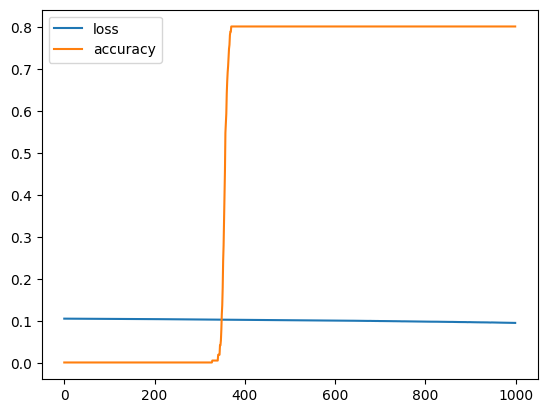

In [ ]:
# plot loss and accuracy
plt.plot(loss_list_gcn)
plt.plot(accuracy_list_gcn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Node2Vec

In [ ]:
node2vec_model = node2vec.Node2Vec(G, dimensions=Cluster_class, num_walks=40, workers=4)

model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

node_ids = list(G.nodes())  # List of nodes in the graph
embedding_matrix = np.array([model.wv[str(node_id)] for node_id in node_ids])

Computing transition probabilities:   0%|          | 0/6519 [00:00<?, ?it/s]

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(embedding_matrix, Y, test_size=0.2, random_state=42)

In [ ]:
kmeans_node = KMeans(n_clusters=Cluster_class)
kmeans_node.fit(X_TRAIN)
Y_PRED_KMEANS_NODE = kmeans_node.predict(X_TRAIN)

print("Training Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TRAIN-1 == Y_PRED_KMEANS_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN-1, Y_PRED_KMEANS_NODE)}")

print()
print("Testing Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TEST-1 == kmeans_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST-1, kmeans_node.predict(X_TEST))}")

Training Accuracy KMeans:
Accuracy: 0.12483221476510067
Adjusted Rand Index: -0.00033422682091110723

Testing Accuracy KMeans:
Accuracy: 0.13420245398773006
Adjusted Rand Index: 0.0007581997626836208


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
lda_node = LinearDiscriminantAnalysis(n_components=2)
lda_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_NODE = lda_node.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_NODE) / len(Y)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_NODE)}")\

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_node.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.6117502684460807
Adjusted Rand Index: 0.0

Testing Accuracy LDA:
Accuracy: 0.7745398773006135
Adjusted Rand Index: 0.0
